In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap, Normalize

import importlib
import utils  # Import your module
from utils import model_name_mapping, metrics_name_mapping

# After making changes to utils.py, reload it
importlib.reload(utils)

# filepath = Path(__file__).parent
filepath = Path(os.path.abspath(''))
print(filepath)

metrics_name_mapping = {
    "r2": "R²",
    "mae": "MAE",
    "rmse": "RMSE",
}

/nfs/lambda_stor_01/data/apartin/projects/IMPROVE/csa-paper-clean


In [2]:
# paths
scores_dir = Path('outputs/s1_scores')
G_dir = Path('outputs/s2_G_matrices')
GaGnGna_dir = Path('outputs/s3_GaGnGna')

outdir = Path('outputs/s3_GaGnGna/figures');
outdir.mkdir(parents=True, exist_ok=True)

# figure config
# file_format = 'eps'
# file_format = 'jpeg'
file_format = 'png'
# file_format = 'tiff'
dpi = 600

filename = 'all_models_scores.csv'
canc_col_name = 'improve_sample_id'
drug_col_name = 'improve_chem_id'

# dataset orders
datasets_order_size = ['gCSI', 'CCLE', 'GDSCv2', 'GDSCv1', 'CTRPv2']
datasets_order_alpha = ['CCLE', 'CTRPv2', 'GDSCv1', 'GDSCv2', 'gCSI']
# default for within-study visuals
datasets_order = datasets_order_size

show_plot = True

all_scores = pd.read_csv(scores_dir / filename, sep=',')
all_scores.iloc[:3,:]

,met,split,value,src,trg,model
0,mse,0,0.006295,CCLE,CCLE,deepcdr
1,mse,1,0.005950,CCLE,CCLE,deepcdr
2,mse,2,0.005129,CCLE,CCLE,deepcdr


In [3]:
# Specify the metric
metric_name = "r2"

# Specify the models you want to include
models_to_include = []  # Replace with your desired models
# models_to_include = ["deepcdr", "deepttc", "graphdrp", "hidra", "lgbm", "uno"]  # Replace with your desired models
# models_to_include = ["graphdrp"]  # Replace with your desired models

In [4]:
# # Average across splits
# sc_mean = all_scores.groupby(['met', 'src', 'trg', 'model'])['value'].mean().reset_index()
# sc_std = all_scores.groupby(['met', 'src', 'trg', 'model'])['value'].std().reset_index()
# sc_mean[:3]

# Within-study results

In [5]:
# Within-study summaries (load precomputed tables; do not recompute here)
mean_path = GaGnGna_dir / 'within_study' / f'{metric_name}_mean_within_study_all_models.csv'
std_path = GaGnGna_dir / 'within_study' / f'{metric_name}_std_within_study_all_models.csv'

df_mean = pd.read_csv(mean_path, index_col=0)
df_std = pd.read_csv(std_path, index_col=0)

# Clear index/column names for display
df_mean.index.name = None
df_mean.columns.name = None
df_std.index.name = None
df_std.columns.name = None

print('Mean across splits (loaded)')
display(df_mean)

print('Std across splits (loaded)')
display(df_std)

Mean across splits (loaded)


,gCSI,CCLE,GDSCv2,GDSCv1,CTRPv2,Mean across models
deepcdr,0.720,0.766,0.760,0.704,0.811,0.752
deepttc,0.759,0.789,0.775,0.737,0.849,0.782
graphdrp,0.736,0.746,0.765,0.733,0.855,0.767
hidra,0.711,0.756,0.768,0.722,0.832,0.758
lgbm,0.782,0.801,0.764,0.695,0.784,0.765
tcnns,0.591,0.705,0.648,0.575,0.639,0.631
uno,0.774,0.796,0.775,0.738,0.841,0.785
Mean across datasets,0.725,0.766,0.751,0.701,0.801,NaN


Std across splits (loaded)


,gCSI,CCLE,GDSCv2,GDSCv1,CTRPv2,Mean across models
deepcdr,0.020,0.023,0.007,0.008,0.005,0.013
deepttc,0.023,0.018,0.010,0.006,0.004,0.012
graphdrp,0.029,0.018,0.008,0.007,0.006,0.014
hidra,0.027,0.020,0.011,0.007,0.005,0.014
lgbm,0.020,0.011,0.008,0.006,0.003,0.010
tcnns,0.061,0.049,0.052,0.049,0.063,0.055
uno,0.025,0.012,0.007,0.007,0.006,0.011
Mean across datasets,0.029,0.021,0.015,0.013,0.013,NaN


In [6]:
datasets_mean = df_mean.loc['Mean across datasets'].drop('Mean across models', errors='ignore') if 'Mean across datasets' in df_mean.index else df_mean.mean(axis=0)
models_mean = df_mean['Mean across models'].drop(labels=['Mean across datasets'], errors='ignore') if 'Mean across models' in df_mean.columns else df_mean.mean(axis=1)

In [7]:
print('datasets_mean:')
display(datasets_mean)
print('models_mean:')
display(models_mean)

datasets_mean:


gCSI      0.725
CCLE      0.766
GDSCv2    0.751
GDSCv1    0.701
CTRPv2    0.801
Name: Mean across datasets, dtype: float64

models_mean:


deepcdr     0.752
deepttc     0.782
graphdrp    0.767
hidra       0.758
lgbm        0.765
tcnns       0.631
uno         0.785
Name: Mean across models, dtype: float64

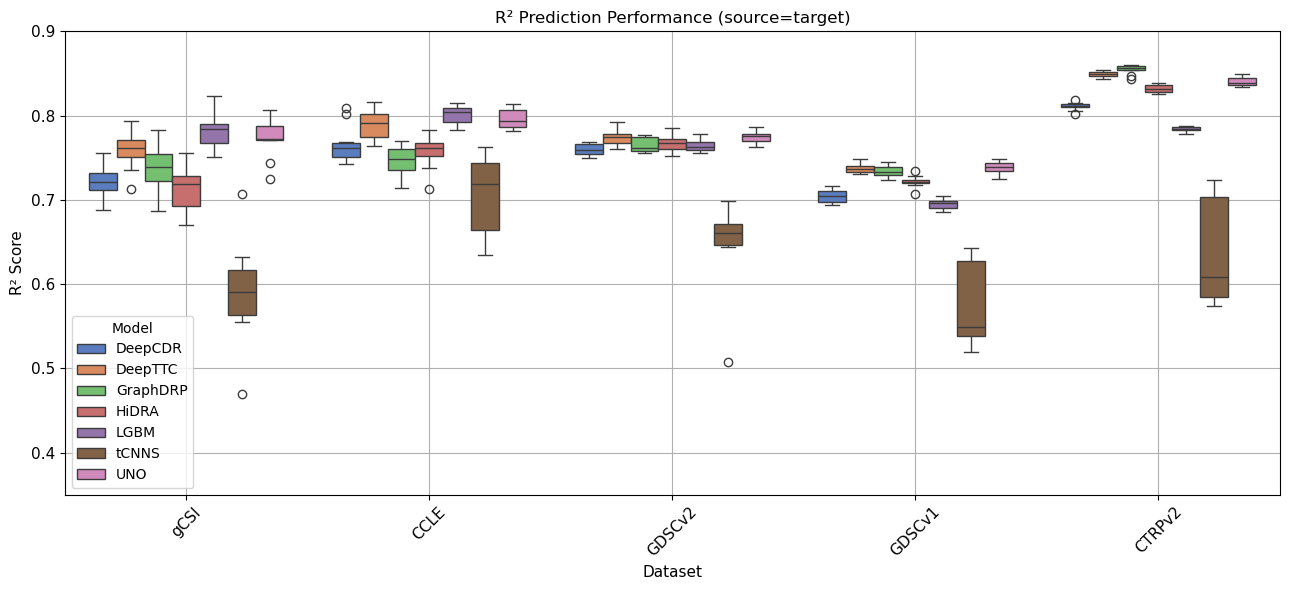

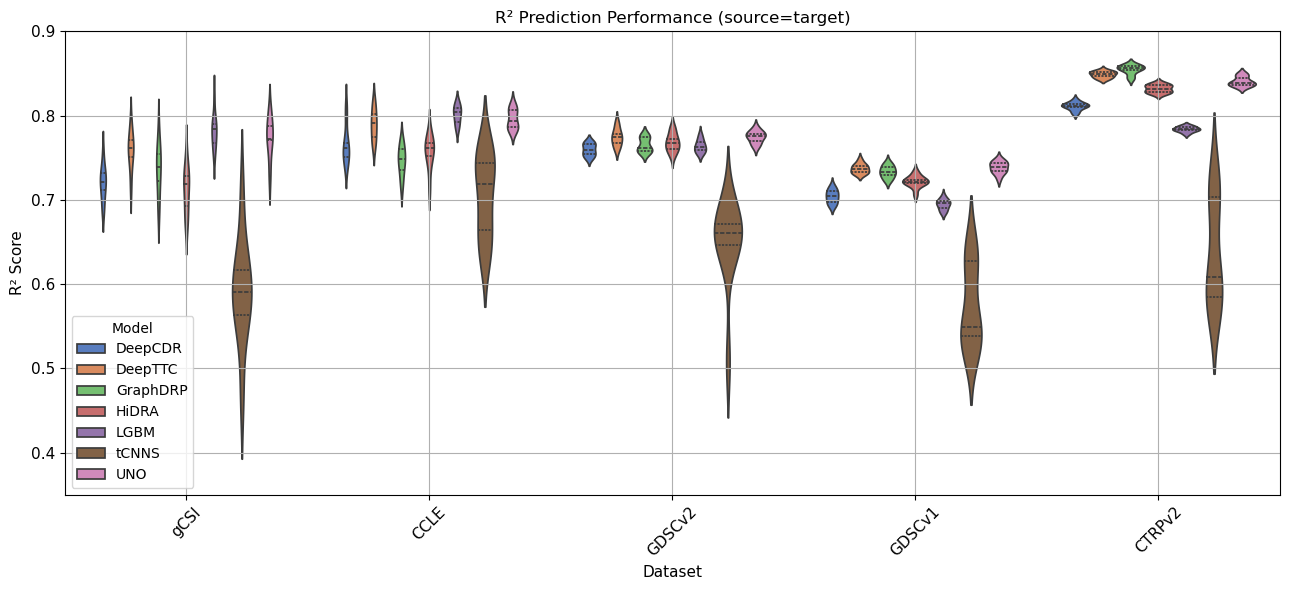

In [8]:
# --------------------------------------------------------------------------------------
# Generalization scores (violin) from a single source to all targets (src != trg)
# --------------------------------------------------------------------------------------

if len(models_to_include) == 0:
    models_to_include = all_scores["model"].unique()

filtered_data = all_scores[
    (all_scores["model"].isin(models_to_include)) & 
    (all_scores["met"] == metric_name) & 
    (all_scores["src"] == all_scores["trg"])
].reset_index(drop=True)

# Map the model names to their corresponding names using model_name_mapping
filtered_data['model'] = filtered_data['model'].map(model_name_mapping)

utils.boxplot_violinplot_within_study(
    df=filtered_data,
    metric_name=metric_name,
    models_to_include=models_to_include,
    outdir=outdir,
    file_format=file_format,
    dpi=dpi,
    ymin=0.35,
    ymax=0.9,
    datasets_order=datasets_order
)

del filtered_data

/tmp/ipykernel_3158025/2659238658.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['model'] = filtered_data['model'].map(model_name_mapping)


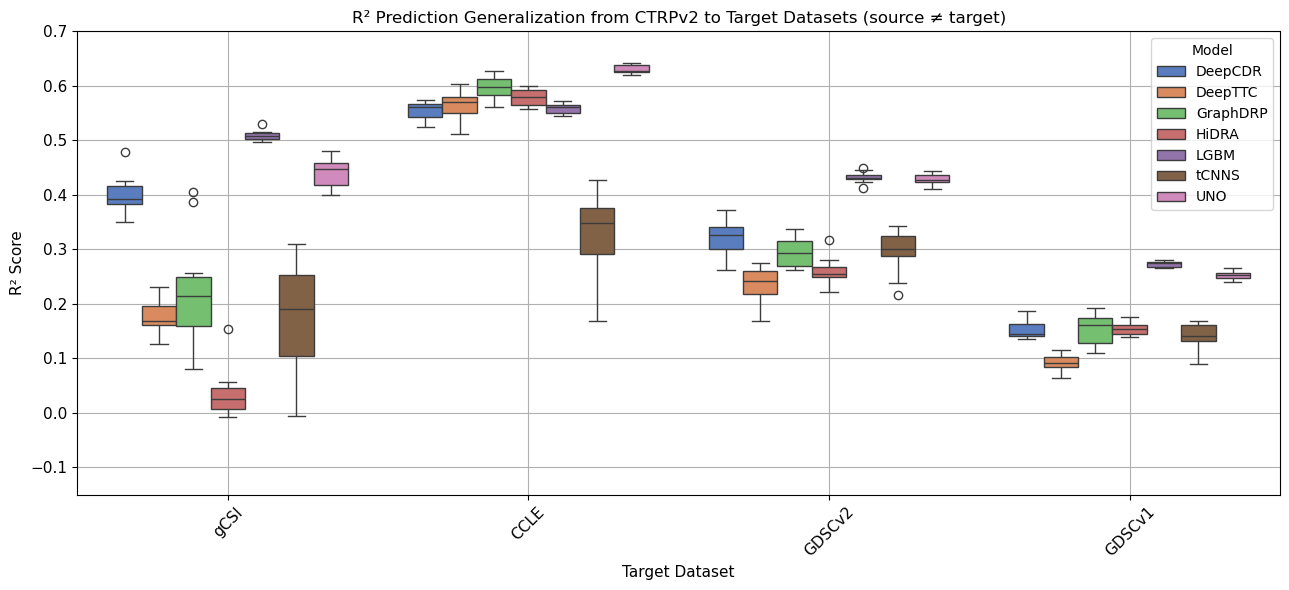

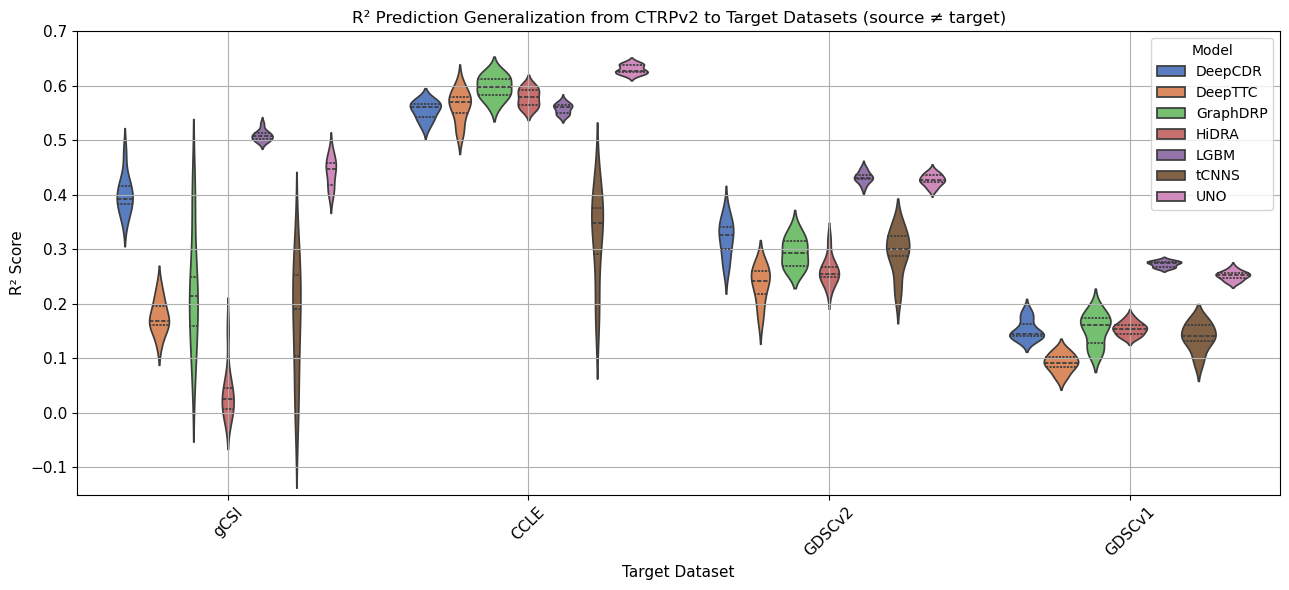

In [9]:
# --------------------------------------------------------------------------------------
# Generalization scores (boxplot) from a single source to all targets (src != trg)
# --------------------------------------------------------------------------------------

# Specify the source dataset for filtering
source_dataset = "CTRPv2"  # Replace with the specific source dataset

if len(models_to_include) == 0:
    models_to_include = all_scores["model"].unique()

# Filter data for specific source dataset (src = CTRPv2), and R^2 metric
filtered_data = all_scores[
    (all_scores["src"] == source_dataset) &
    (all_scores["src"] != all_scores["trg"]) &  # Exclude cases where src = trg
    (all_scores["met"] == metric_name) &
    (all_scores["model"].isin(models_to_include))  # Include only specified models
]

# Map the model names to their corresponding names using model_name_mapping
filtered_data['model'] = filtered_data['model'].map(model_name_mapping)

utils.boxplot_violinplot_cross_study(
    df=filtered_data, 
    source_dataset=source_dataset, 
    metric_name=metric_name, 
    models_to_include=models_to_include, 
    outdir=outdir,
    file_format=file_format,
    dpi=dpi,
    ymin=-0.15,
    ymax=0.7,
    datasets_order=[x for x in datasets_order if x != source_dataset]
)

del filtered_data

deepcdr


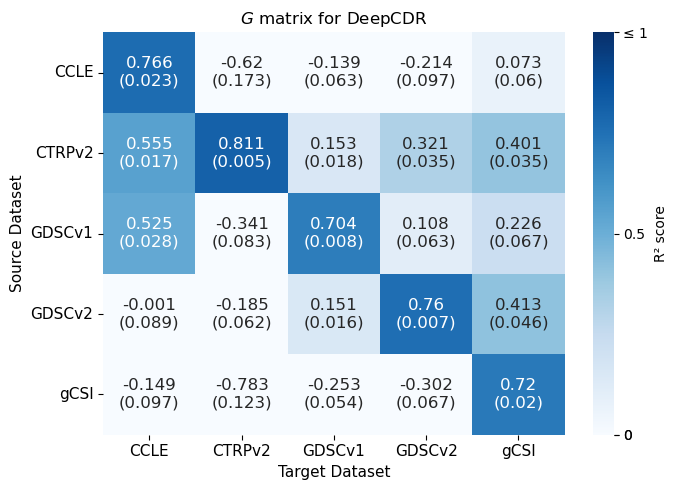

deepttc


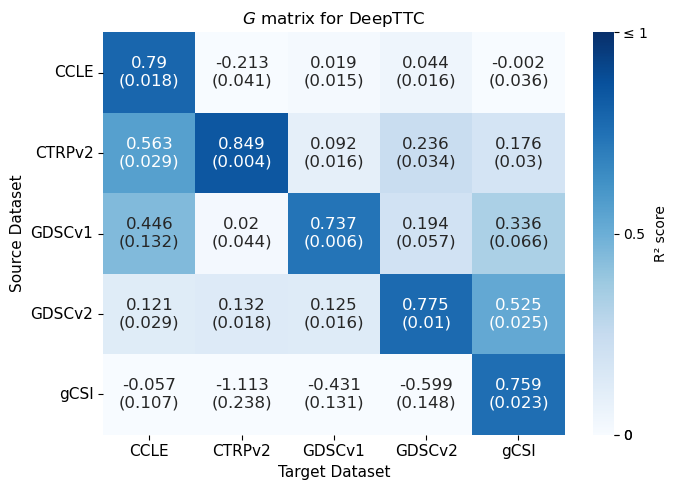

graphdrp


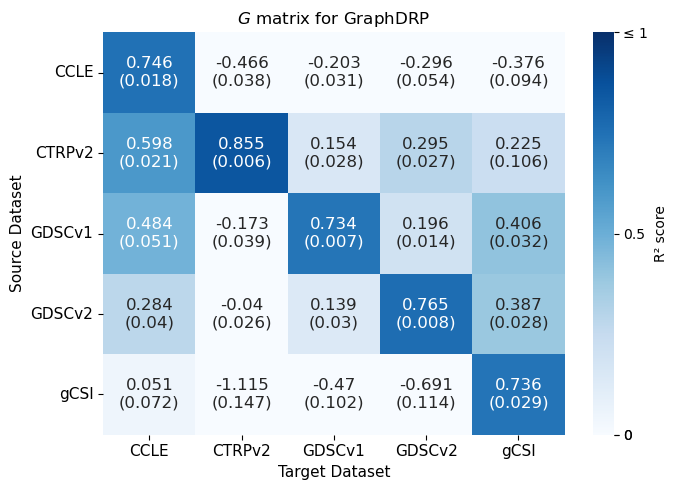

hidra


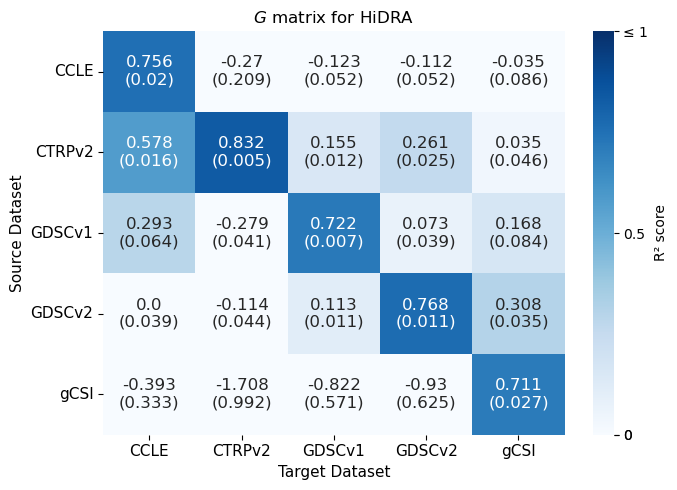

lgbm


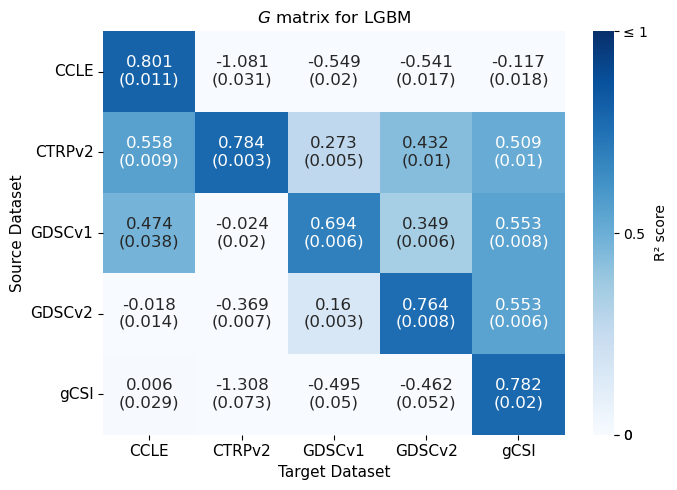

tcnns


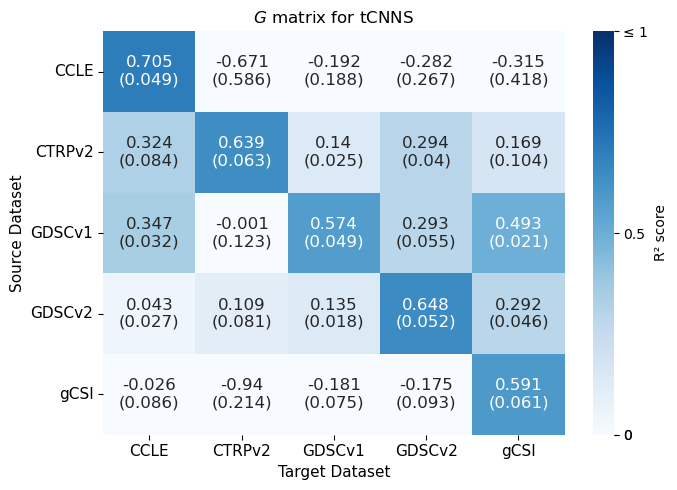

uno


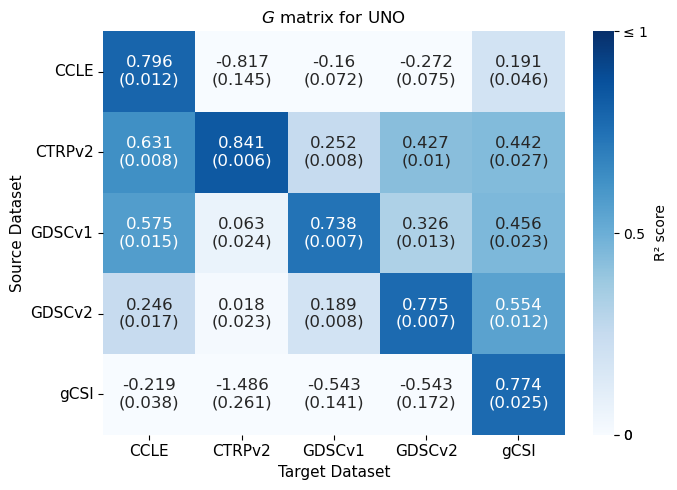

In [10]:
# Raw G matrices for all models (including std in parentheses) (Linear Scale)

G_palette = 'Blues'

G_mean_dfs = {}
G_std_dfs = {}

for model_name in model_name_mapping.keys():
    print(model_name)
    mean_filename = f'{model_name}_{metric_name}_G_mean.csv'
    std_filename = f'{model_name}_{metric_name}_G_std.csv'

    G_mean = pd.read_csv(G_dir / mean_filename, sep=',', index_col=0)
    G_std = pd.read_csv(G_dir / std_filename, sep=',', index_col=0)

    G_mean_dfs[model_name] = G_mean
    G_std_dfs[model_name] = G_std

    utils.csa_heatmap(
        model_name=model_name, 
        metric_name=f"{metrics_name_mapping[metric_name]}",
        csa_metric_name='G',
        scores_csa_data=G_mean, 
        std_csa_data=G_std,
        vmin=0,
        vmax=1,
        outdir=outdir,
        file_format=file_format,
        dpi=dpi,
        palette=G_palette,
        decimal_digits=3,
        show=show_plot
    )

del model_name, G_mean, G_std

# Custom metrics (Ga, Gn, Gna)

In [11]:
# Use scores from a single model

# # Example CSA scores (R²)
# scores_csa_data = {
#     "CCLE": [0.7479, 0.5758, 0.4482, 0.3082, 0.0234],
#     "CTRPv2": [-0.4671, 0.8508, -0.1432, -0.0324, -1.1319],
#     "GDSCv1": [-0.2057, 0.1503, 0.734, 0.154, -0.4801],
#     "GDSCv2": [-0.2913, 0.2902, 0.2003, 0.7659, -0.7147],
#     "gCSI": [-0.3793, 0.2314, 0.4179, 0.3914, 0.733],
# }
# scores_csa_data = pd.DataFrame(scores_csa_data, index=["CCLE", "CTRPv2", "GDSCv1", "GDSCv2", "gCSI"])

# # Example CSA std deviations (optional for some metrics)
# std_csa_data = {
#     "CCLE": [0.0123, 0.0406, 0.0245, 0.0364, 0.1058],
#     "CTRPv2": [0.0249, 0.0031, 0.0135, 0.0253, 0.0901],
#     "GDSCv1": [0.078, 0.0301, 0.0065, 0.0389, 0.0304],
#     "GDSCv2": [0.0453, 0.0216, 0.0262, 0.0098, 0.0448],
#     "gCSI": [0.1053, 0.1546, 0.0903, 0.1144, 0.0314],
# }
# std_csa_data = pd.DataFrame(std_csa_data, index=["CCLE", "CTRPv2", "GDSCv1", "GDSCv2", "gCSI"])

model_name = "graphdrp"

mean_filename = f'{model_name}_{metric_name}_G_mean.csv'
std_filename = f'{model_name}_{metric_name}_G_std.csv'

scores = pd.read_csv(G_dir / mean_filename, sep=',', index_col=0)
stds = pd.read_csv(G_dir / std_filename, sep=',', index_col=0)

print(f'Model: {model_name}')
display(scores)
display(stds)

Model: graphdrp


,CCLE,CTRPv2,GDSCv1,GDSCv2,gCSI
src,,,,,
CCLE,0.7463,-0.4658,-0.2034,-0.2956,-0.3757
CTRPv2,0.5975,0.8548,0.1536,0.2946,0.2248
GDSCv1,0.4837,-0.1727,0.7335,0.1963,0.4063
GDSCv2,0.2838,-0.0400,0.1392,0.7654,0.3867
gCSI,0.0507,-1.1147,-0.4700,-0.6911,0.7359


,CCLE,CTRPv2,GDSCv1,GDSCv2,gCSI
src,,,,,
CCLE,0.017624,0.037721,0.031389,0.053909,0.094062
CTRPv2,0.020908,0.005561,0.028340,0.026835,0.105501
GDSCv1,0.051223,0.039108,0.007105,0.013770,0.032113
GDSCv2,0.039580,0.025730,0.029556,0.008478,0.027771
gCSI,0.072315,0.146593,0.102085,0.113874,0.029452


# Ga matrix

In [12]:
# Compute Ga using both implementations
Ga_bruteforce = utils.compute_aggregated_G_bruteforce(scores, normalize=False)
Ga_vectorized = utils.compute_aggregated_G_vectorized(scores, normalize=False)

# Compare results
print(f"Bruteforce Ga:\n{Ga_bruteforce}")
print(f"Vectorized Ga:\n{Ga_vectorized}")

# Check if all implementations are consistent
assert Ga_vectorized == Ga_bruteforce, "Mismatch between bruteforce and vectorized implementations!"

Bruteforce Ga:
{'CCLE': -0.335125, 'CTRPv2': 0.31762500000000005, 'GDSCv1': 0.22840000000000002, 'GDSCv2': 0.192425, 'gCSI': -0.5562750000000001}
Vectorized Ga:
{'CCLE': -0.335125, 'CTRPv2': 0.31762500000000005, 'GDSCv1': 0.22840000000000002, 'GDSCv2': 0.192425, 'gCSI': -0.5562750000000001}


In [13]:
# Combine Ga scores from all models
Ga_list = []

for model_name in model_name_mapping.keys():
    print(model_name)
    
    mean_filename = f'{model_name}_{metric_name}_G_mean.csv'
    scores_csa_data = pd.read_csv(G_dir / mean_filename, sep=',', index_col=0)
    Ga = utils.compute_aggregated_G_vectorized(scores_csa_data, normalize=False)

    Ga['model'] = model_name
    Ga_list.append(Ga)

Ga_df = pd.DataFrame(Ga_list)
Ga_df.insert(loc=0, column='model', value=Ga_df.pop('model')) # place 'model' col at pos 0
Ga_df.set_index('model', inplace=True)
Ga_df.to_csv(outdir / 'Ga_table.csv')
print(Ga_df)

del model_name, scores_csa_data, Ga, Ga_list

deepcdr
deepttc
graphdrp
hidra
lgbm
tcnns
uno
              CCLE    CTRPv2    GDSCv1    GDSCv2      gCSI
model                                                     
deepcdr  -0.224750  0.357575  0.129200  0.094275 -0.371600
deepttc  -0.038125  0.266750  0.248750  0.225800 -0.549950
graphdrp -0.335125  0.317625  0.228400  0.192425 -0.556275
hidra    -0.134950  0.257275  0.063550  0.076700 -0.963125
lgbm     -0.571975  0.443175  0.338050  0.081525 -0.564775
tcnns    -0.365100  0.231750  0.282875  0.144800 -0.330475
uno      -0.264450  0.438000  0.354875  0.251925 -0.697675


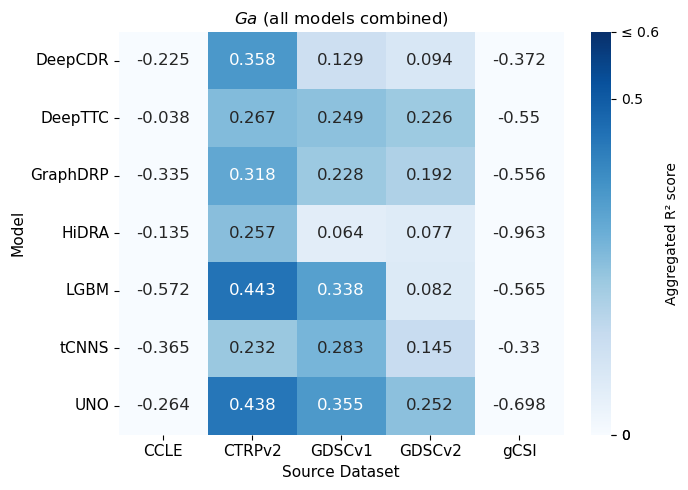

In [14]:
# Plot Ga heatmap
utils.aggregated_G_heatmap(
    metric_name=f"Aggregated {metrics_name_mapping[metric_name]}",
    csa_metric_name='Ga',
    scores_aggregated_data=Ga_df.copy(),
    # palette="RdPu",
    palette=G_palette,
    vmin=0,
    vmax=0.6,
    outdir=outdir,
    file_format=file_format,
    dpi=dpi,
    show=show_plot
)

# Gn matrix

In [15]:
# Compute Gn using both implementations
Gn_bruteforce = utils.compute_Gn_bruteforce(scores)
Gn_vectorized = utils.compute_Gn_vectorized(scores)

# Convert bruteforce results to DataFrame for comparison
Gn_bruteforce_df = pd.DataFrame.from_dict(Gn_bruteforce, orient="index")

# Compare results
print(f'Bruteforce Gn:\n{Gn_bruteforce_df}')
print(f'\nVectorized Gn:\n{Gn_vectorized}')

# Check for equality
assert np.allclose(Gn_bruteforce_df, Gn_vectorized), "Gn results do not match!"
print("\nBoth implementations produce the same results!")

Bruteforce Gn:
            CCLE    CTRPv2    GDSCv1    GDSCv2      gCSI
CCLE    1.000000 -0.624146 -0.272545 -0.396087 -0.503417
CTRPv2  0.698994  1.000000  0.179691  0.344642  0.262985
GDSCv1  0.659441 -0.235446  1.000000  0.267621  0.553920
GDSCv2  0.370787 -0.052260  0.181866  1.000000  0.505226
gCSI    0.068895 -1.514744 -0.638674 -0.939122  1.000000

Vectorized Gn:
            CCLE    CTRPv2    GDSCv1    GDSCv2      gCSI
src                                                     
CCLE    1.000000 -0.624146 -0.272545 -0.396087 -0.503417
CTRPv2  0.698994  1.000000  0.179691  0.344642  0.262985
GDSCv1  0.659441 -0.235446  1.000000  0.267621  0.553920
GDSCv2  0.370787 -0.052260  0.181866  1.000000  0.505226
gCSI    0.068895 -1.514744 -0.638674 -0.939122  1.000000

Both implementations produce the same results!


deepcdr


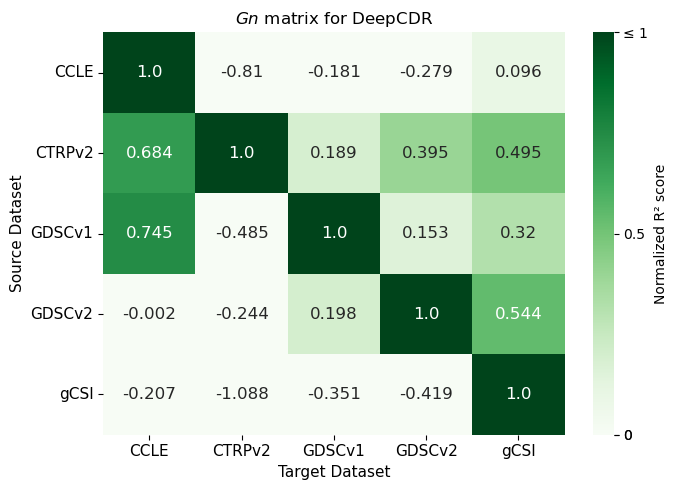

deepttc


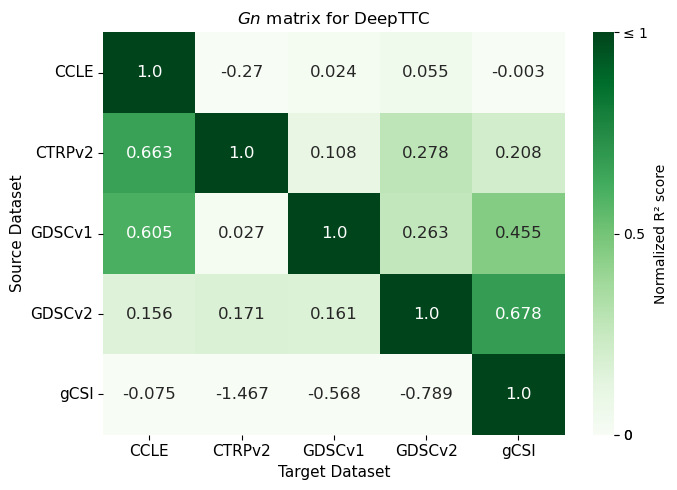

graphdrp


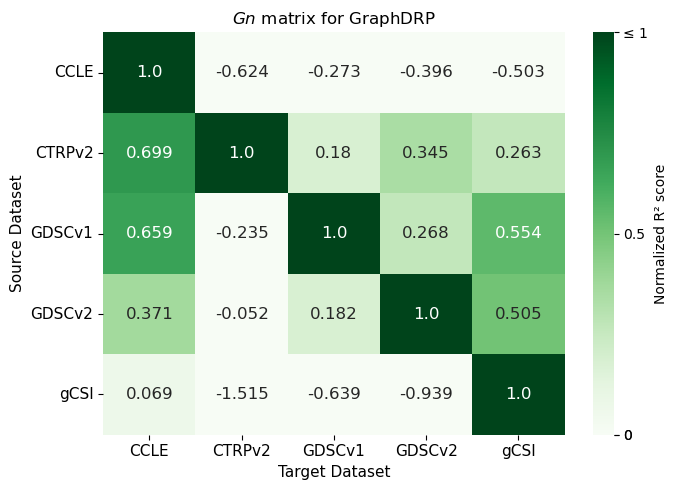

hidra


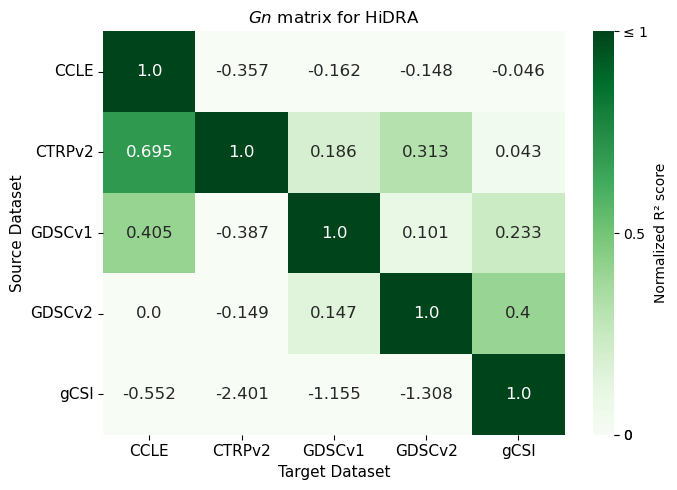

lgbm


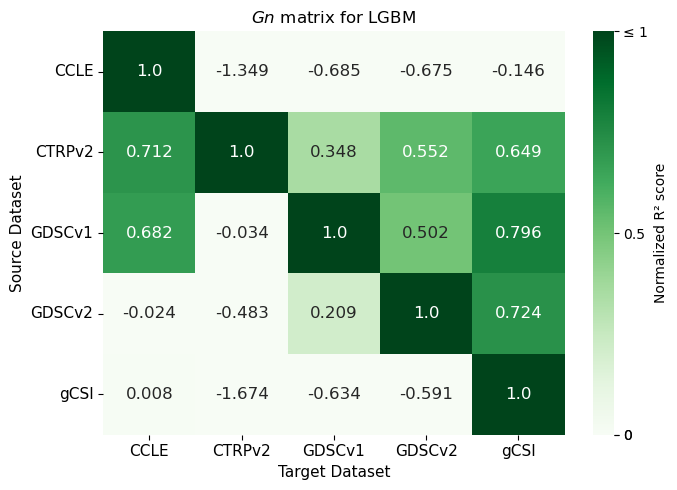

tcnns


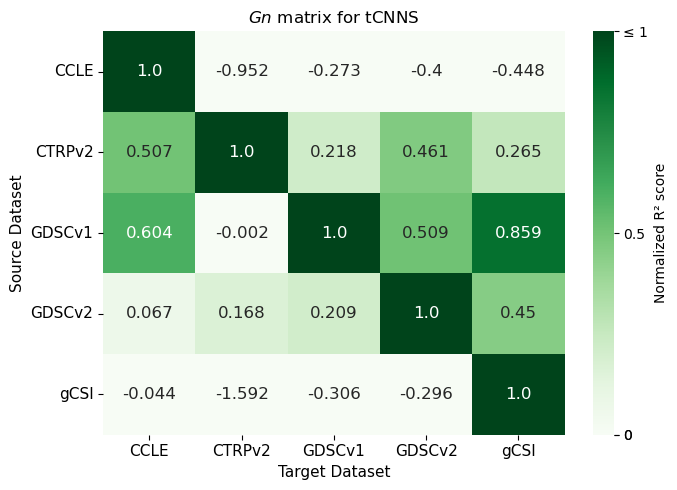

uno


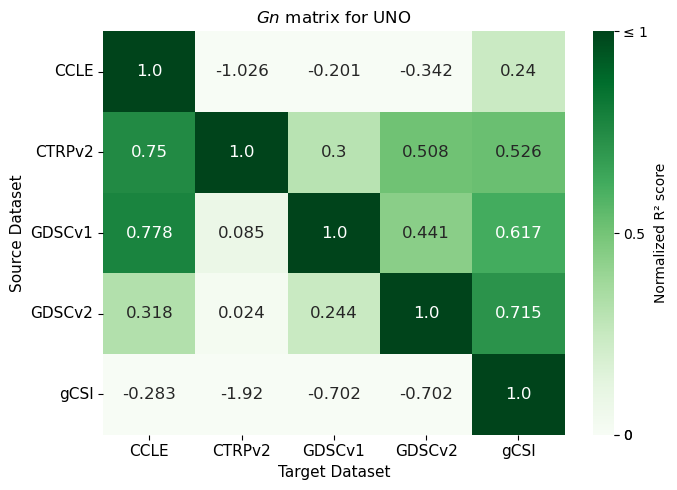

In [16]:
Gn_palette = 'Greens'

for model_name in model_name_mapping.keys():
    print(model_name)
    
    gn_path = GaGnGna_dir / f'{model_name}_{metric_name}_Gn_mean.csv'
    if gn_path.exists():
        Gn = pd.read_csv(gn_path, index_col=0)
    else:
        mean_filename = f'{model_name}_{metric_name}_G_mean.csv'
        scores_csa_data = pd.read_csv(G_dir / mean_filename, sep=',', index_col=0)
        Gn = utils.compute_Gn_vectorized(scores_csa_data)

    utils.csa_heatmap(
        model_name=model_name, 
        metric_name=f"Normalized {metrics_name_mapping[metric_name]}",
        csa_metric_name='Gn',
        scores_csa_data=Gn, 
        vmin=0,
        vmax=1,
        palette=Gn_palette,
        outdir=outdir,
        file_format=file_format,
        dpi=dpi,
        decimal_digits=3,
        show=show_plot
    )

del model_name, Gn

# Gna matrix

In [17]:
# Compute Gna using both implementations
Gna_bruteforce = utils.compute_aggregated_G_bruteforce(scores, normalize=True)
Gna_vectorized = utils.compute_aggregated_G_vectorized(scores, normalize=True)

# Compare results
print("Bruteforce Gna:")
print(Gna_bruteforce)

print("\nVectorized Gna:")
print(Gna_vectorized)

# Check if all implementations are consistent
# assert Gna_vectorized.equals(pd.Series(Gna_bruteforce)), "Mismatch between bruteforce and simpler implementations!"
assert Gna_vectorized == Gna_bruteforce, "Mismatch between bruteforce and vectorized implementations!"

Bruteforce Gna:
{'CCLE': -0.44904863995712174, 'CTRPv2': 0.3715781469349555, 'GDSCv1': 0.31138377641445125, 'GDSCv2': 0.2514044943820225, 'gCSI': -0.7559111292295149}

Vectorized Gna:
{'CCLE': -0.44904863995712174, 'CTRPv2': 0.3715781469349555, 'GDSCv1': 0.31138377641445125, 'GDSCv2': 0.2514044943820225, 'gCSI': -0.7559111292295149}


In [18]:
# Combine Gna scores from all models
Gna_list = []

for model_name in model_name_mapping.keys():
    print(model_name)
    
    mean_filename = f'{model_name}_{metric_name}_G_mean.csv'
    scores_csa_data = pd.read_csv(G_dir / mean_filename, sep=',', index_col=0)
    Gna = utils.compute_aggregated_G_vectorized(scores_csa_data, normalize=True)

    Gna['model'] = model_name
    Gna_list.append(Gna)

Gna_df = pd.DataFrame(Gna_list)
Gna_df.insert(loc=0, column='model', value=Gna_df.pop('model')) # place 'model' col at pos 0
Gna_df.set_index('model', inplace=True)
Gna_df.to_csv(outdir / 'Gna_table.csv')
print(Gna_df)

del model_name, scores_csa_data, Gna, Gna_list

deepcdr
deepttc
graphdrp
hidra
lgbm
tcnns
uno
              CCLE    CTRPv2    GDSCv1    GDSCv2      gCSI
model                                                     
deepcdr  -0.293446  0.440743  0.183497  0.124095 -0.516398
deepttc  -0.048290  0.314230  0.337380  0.291505 -0.724954
graphdrp -0.449049  0.371578  0.311384  0.251404 -0.755911
hidra    -0.178387  0.309188  0.088044  0.099831 -1.354035
lgbm     -0.713720  0.565274  0.486753  0.106694 -0.722588
tcnns    -0.518019  0.362903  0.492385  0.223388 -0.559369
uno      -0.332182  0.520994  0.480535  0.325148 -0.901622


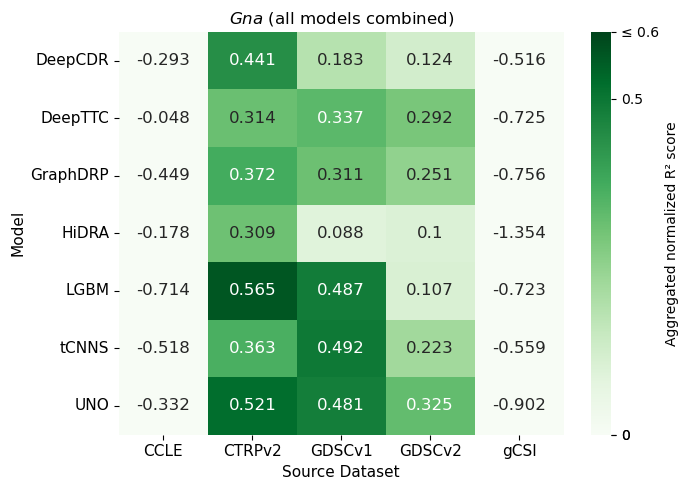

In [19]:
# Plot Gna heatmap
utils.aggregated_G_heatmap(
    metric_name=f"Aggregated normalized {metrics_name_mapping[metric_name]}",
    csa_metric_name='Gna',
    scores_aggregated_data=Gna_df.copy(),
    # palette="RdPu",
    palette=Gn_palette,
    vmin=0,
    vmax=0.6,
    outdir=outdir,
    file_format=file_format,
    dpi=dpi,
    show=show_plot
)